<a href="https://colab.research.google.com/github/EAName/yelp-reviews/blob/main/Yelp_NLP_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import random
import numpy as np
import pickle 
import re,string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC



from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_predict


import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, CoherenceModel
from gensim import corpora
from gensim import similarities
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GRU
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from keras import Input

from IPython.display import display

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/Data/yelp_reviews_clean_version4_st_louis.csv')

In [6]:
df.shape

(292376, 5)

Text(0.5, 0, 'Star Ratings ')

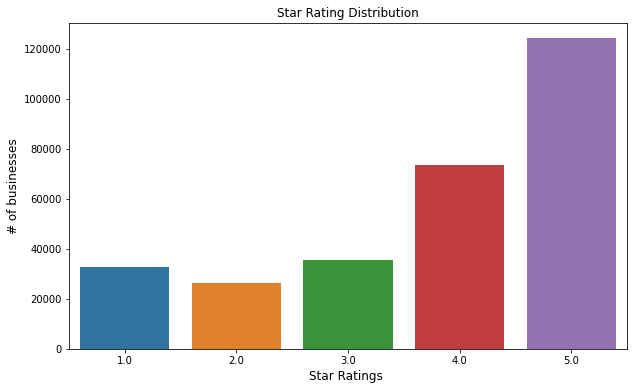

In [7]:
plt.figure(figsize=(10,6))
ax = sns.countplot(df['stars'])
plt.title('Distribution of rating');
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

In [8]:
# sample 10,000 reviews
df = df.sample(n=10000, random_state=1)

Text(0.5, 0, 'Star Ratings ')

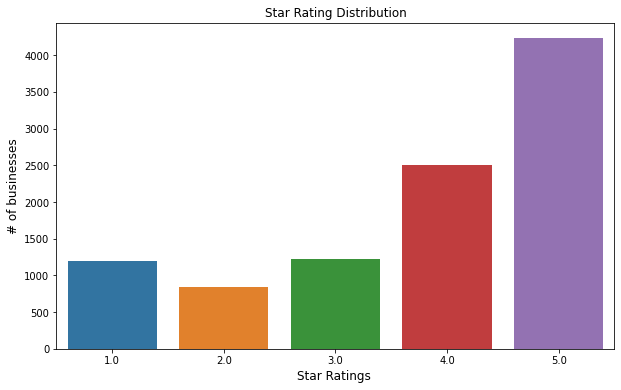

In [9]:
plt.figure(figsize=(10,6))
ax = sns.countplot(df['stars'])
plt.title('Distribution of rating');
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

**Extract year**

In [10]:
df['review_year'] = df['date'].apply(lambda x:int(x[:4]))

**Look at distribution of reviews by year**

In [11]:
df.review_year.value_counts(ascending= True)

2006      11
2007      24
2022      32
2008     101
2009     112
2010     308
2011     456
2012     531
2013     616
2020     646
2021     746
2014     779
2015     998
2016    1079
2017    1127
2018    1181
2019    1253
Name: review_year, dtype: int64

**Create 1-0 sentiment flag**

In [12]:
df['sentiment'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

**Drop reviews older than 2011**

In [13]:
#df = df[(df['review_year'] > 2011)]

In [14]:
#df.shape

## Text Preprocessing 

In [15]:
def clean_doc(doc): 
    #split review into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    #word lemmzatization    
    lemm = WordNetLemmatizer()
    tokens=[lemm.lemmatize(word) for word in tokens]

    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 3]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]     

    # filter out common words
    #tokens = [w for w in tokens if not w in ['movie', 'movies', 'films']]      
    # # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]

    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

In [16]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_doc(x))

final_processed_text = [' '.join(x) for x in df['cleaned_text'].tolist()]
df['final_processed_text'] = final_processed_text     #add to dataframe

In [17]:
df['text length'] = df['text'].apply(len)

In [18]:
final_processed_text[0]

'came around third person party wasnt supposed arrive around seated promptly even without full party dont busy ordered risotto ball couldnt wait third person arrive digging gooey little bite deliciousness order offered fresh sliced bread dont deny thats darn good bread everyone arrived ordered pasta suggestion waitress helpful knowledgeable menu also asked mixed soda drink wasnt cherry limeade said bartender could something ended previous month specialty drink raspberry black pepper meal complete enjoyed tasting ending meal gelato well back soon phenomenal looking pizza update came back pizza gelato baseball game enjoyed especially foodie'

In [19]:
#df.to_csv('/content/gdrive/MyDrive/data/yelp_reviews_pre_processed_v2.csv', index = False)

In [20]:
#df = pd.read_csv('/content/gdrive/MyDrive/data/yelp_reviews_pre_processed_v2.csv')

In [21]:
df.head()

,user_id,business_id,date,stars,text,review_year,sentiment,cleaned_text,final_processed_text,text length
34977,J77sLuzhywuyDI2ro0ySkQ,YSgcojsb2kWHXNLWaGCuBA,2016-07-26 19:43:56,5.0,My mom and I came in around 5:15 and the third...,2016,1,"[came, around, third, person, party, wasnt, su...",came around third person party wasnt supposed ...,1065
225241,Nzy7auzEFEN5wthmL9a00w,jME5VhjMZvNKsQJwsPKL7Q,2016-08-22 16:50:49,4.0,Great place for lunch. Inside and Outside seat...,2016,1,"[great, place, lunch, inside, outside, seating...",great place lunch inside outside seating food ...,172
202828,VZGTPhVezGAIxsYgrhCLyw,s7JxSEtIumoFod2Jdj0_-g,2018-11-22 12:00:07,1.0,Horrible experience! Owner is completely rude ...,2018,0,"[horrible, experience, owner, completely, rude...",horrible experience owner completely rude unpr...,193
107110,o15SFerEo23dMSiY_P2xEw,oC91lprbbfzw7DOYiYln7Q,2014-11-16 18:05:18,4.0,Didn't realize I hadn't written review on this...,2014,1,"[didnt, realize, hadnt, written, review, place...",didnt realize hadnt written review place good ...,893
52350,gFttJC8-aX5bXcUuqyH5CA,9llupBLdHKFzfawIk6I74w,2013-08-30 01:16:57,4.0,I have been here like 5 times and everytime I ...,2013,1,"[like, time, everytime, like, coming, back, re...",like time everytime like coming back restauran...,1554


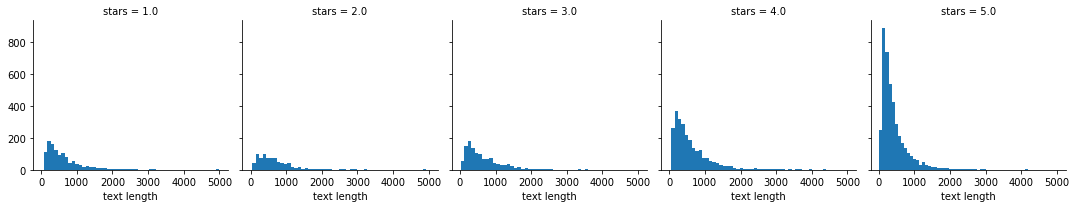

In [22]:
# Lets visualise the review text and stars for a business
g = sns.FacetGrid(data=df, col='stars')
g.map(plt.hist, 'text length', bins=50)

###K-Mean Clustering

In [66]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range= ngram_range, max_features = 2000)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

In [74]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]

    #dictionary to store clusters and respective titles
    cluster_terms={}
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.  

    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        temp=frame[frame['Cluster']==i]
        docs_list = temp['Doc Name'].tolist()
        cluster_matrix = tfidf_matrix.loc[docs_list]

        df1 = pd.DataFrame(columns = ['term', 'Average tf-idf score'])

        for ind in order_centroids[i, :20]:
            #print(' %s' % terms[ind])
            #print(round(cluster_matrix.iloc[:,ind].mean(),5))
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
                        
            df1 = df1.append({'term': terms[ind], 'Average tf-idf score':round(cluster_matrix.iloc[:,ind].mean(),4) }, ignore_index = True)
        cluster_terms[i]=temp_terms
        print(df1)
        print("\n")

        #print("Cluster %d titles:" % i, end = '')
        temp=frame[frame['Cluster']==i]
        print('Cluster size: ', len(temp['Doc Name']))
        # for title in temp['Doc Name']:
        #     print(' %s' % title, end='\n')
        #     temp_titles.append(title)
        # cluster_title[i]=temp_titles
        print("\n")


    return cluster_title,clusters,frame

In [34]:
titles = list(range(10000))

In [69]:
tfidf_matrix, terms = tfidf(final_processed_text, titles, ngram_range = (1,1))

In [37]:
k_list = [5, 8, 10]

#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)

In [41]:
k_list2 = [4, 6, 7, 9]

#silhoutte score list
#sil_scores2 = []

for k in k_list2:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)
    k_list.append(k)

In [61]:
k_list3 = [2, 3, 11, 12]

#silhoutte score list
#sil_scores2 = []

for k in k_list3:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)
    k_list.append(k)

In [63]:
sil = list(zip(k_list,sil_scores))
sil_df = pd.DataFrame(sil, columns = ['k_list', 'sil_scores'])
sil_df = sil_df.sort_values(by=['k_list'])

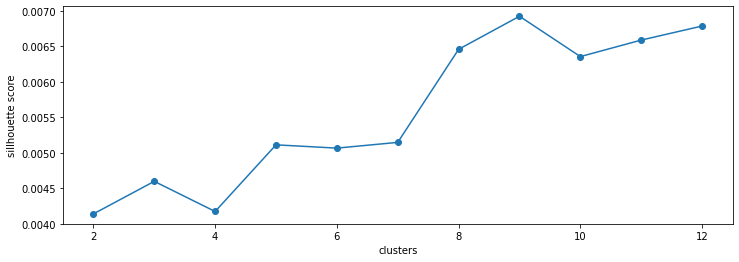

In [65]:
# plot silhouette score
plt.figure(figsize=(12, 4))
plt.scatter(sil_df['k_list'], sil_df['sil_scores'])
plt.plot(sil_df['k_list'], sil_df['sil_scores'])
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()

In [75]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k =9)

Top terms per cluster:
Cluster 0:
         term  Average tf-idf score
0        taco                0.2656
1       salsa                0.0804
2     mexican                0.0684
3        chip                0.0465
4        fish                0.0462
5        good                0.0452
6        food                0.0447
7   margarita                0.0438
8       great                0.0315
9   delicious                0.0306
10    burrito                0.0291
11     street                0.0280
12      place                0.0280
13       like                0.0273
14   tortilla                0.0268
15       back                0.0263
16    amazing                0.0255
17    chicken                0.0246
18     really                0.0242
19       time                0.0238


Cluster size:  275


Cluster 1:
         term  Average tf-idf score
0       pizza                0.3253
1       crust                0.0574
2        good                0.0446
3       salad                0.0

### LSA Topic Modeling

In [79]:
processed_text = df['cleaned_text'].tolist()

In [118]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

  # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
  dictionary = corpora.Dictionary(doc_clean)
  # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
  doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
  # generate LSA model
  #lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, onepass = False, power_iters = 10)  # train model
  lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
  display(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
  print('\n')
  index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix]) # using cosine similarity

  corpus_lsa = lsamodel[doc_term_matrix]

  # Cluster documents by highest value in vector
  doc_clusters_1 = []
  for doc in corpus_lsa:
    flattened = [val for sublist in doc for val in sublist]
    new_list = flattened[1:][::2]
    max_value = max(new_list, key = abs)
    index_value = new_list.index(max_value)
    doc_clusters_1.append(doc[index_value][0])

#   df2 = pd.DataFrame(doc_clusters_1, columns = 'clusters')
  df2 = df.iloc[:,1:2]
  df2['clusters'] = doc_clusters_1
  df2['sentiment'] = df['sentiment']
  df2['stars'] = df['stars']
  df2 = df2.sort_values(by=['clusters', 'sentiment'])
#   #display(df)

  print(df2.groupby(['clusters', 'sentiment']).count())
  print('\n')
  print(df2.groupby(['clusters', 'stars']).count())

 # return lsamodel,dictionary,index

In [119]:
create_gensim_lsa_model(processed_text,9, 10)

[(0,
  '0.324*"food" + 0.295*"good" + 0.252*"place" + 0.195*"time" + 0.186*"like" + 0.182*"great" + 0.149*"service" + 0.140*"back" + 0.140*"really" + 0.138*"would"'),
 (1,
  '0.570*"food" + -0.416*"good" + -0.385*"pizza" + -0.159*"sauce" + 0.146*"service" + -0.137*"cheese" + -0.123*"really" + 0.120*"minute" + -0.120*"like" + 0.113*"time"'),
 (2,
  '0.430*"great" + 0.386*"food" + 0.310*"good" + 0.233*"place" + -0.196*"order" + -0.196*"table" + -0.187*"pizza" + -0.154*"would" + -0.150*"time" + -0.147*"ordered"'),
 (3,
  '0.625*"pizza" + -0.454*"good" + 0.374*"place" + 0.286*"great" + -0.143*"chicken" + 0.084*"time" + -0.082*"ordered" + 0.079*"crust" + -0.078*"really" + -0.075*"side"'),
 (4,
  '-0.482*"pizza" + -0.475*"good" + -0.399*"food" + 0.341*"great" + 0.244*"place" + 0.114*"menu" + 0.100*"chicken" + 0.099*"like" + 0.088*"also" + 0.082*"sauce"'),
 (5,
  '0.649*"place" + -0.565*"great" + 0.212*"like" + -0.172*"service" + -0.159*"pizza" + -0.114*"salad" + -0.099*"ordered" + -0.089*"ch



                    business_id  stars
clusters sentiment                    
0        0                 2760   2760
         1                 5322   5322
1        0                   99     99
         1                  144    144
2        0                   75     75
         1                  290    290
3        0                   81     81
         1                  233    233
4        0                   35     35
         1                   77     77
5        0                   59     59
         1                  392    392
6        0                   39     39
         1                   93     93
7        0                   58     58
         1                  151    151
8        0                   52     52
         1                   40     40


                business_id  sentiment
clusters stars                        
0        1.0            956        956
         2.0            729        729
         3.0           1075       1075
         4.0         